**import Required libraries :**


In [12]:
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt





# Implementing a basic background subtractor :
Background subtraction (BS) is a common and widely used technique for generating a foreground mask (namely, a binary image containing the pixels belonging to moving objects in the scene) by using static cameras.
As the name suggests, BS calculates the foreground mask performing a subtraction between the current frame and a background model, containing the static part of the scene or, more in general, everything that can be considered as background given the characteristics of the observed scene.
ackground modeling consists of two main steps:

1. Background Initialization
2. Background Update
In the first step, an initial model of the background is computed, while in the second step that model is updated in order to adapt to possible changes in the scene.

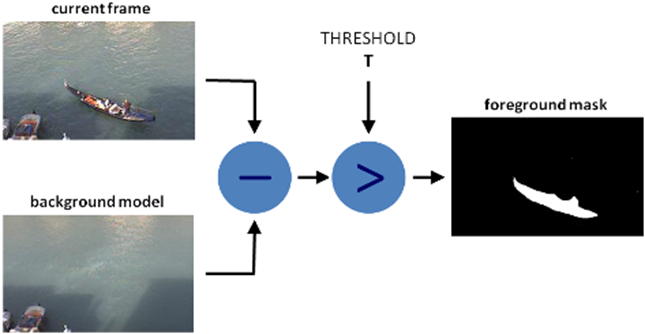

To implement a basic background subtractor, let's take the following approach:
1. Start capturing frames from a camera.
2. Discard nine frames so that the camera has time to properly adjust its autoexposure to suit the lighting conditions in the scene.
3. Take the 10th frame, convert it to grayscale, blur it, and use this blurred image as the reference image of the background.
4. For each subsequent frame, blur the frame, convert it to grayscale, and compute the absolute difference between this blurred frame and the reference image of the background. Perform thresholding, smoothing, and contour detection on the differenced image. Draw and show the bounding boxes of the major contours.

More details in :[📄OpenCV_Course.pdf](https://github.com/ZahraEk/OpenCV-Course/blob/main/OpenCV_Course.pdf) | pages 8-12





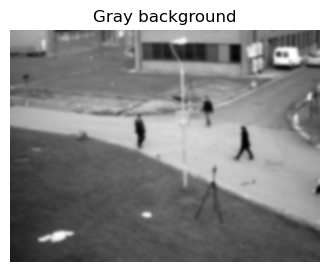

In [13]:
# Define the blur radius and kernel sizes for erosion and dilation
BLUR_RADIUS = 21
erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))

# URL to the raw video file on GitHub
video_url = "https://github.com/ZahraEk/OpenCV-Course/raw/main/videos/pedestrians.avi"

# Download the video
video_filename = "pedestrians.avi"
urllib.request.urlretrieve(video_url, video_filename)

# Open the video file for reading
cap = cv2.VideoCapture(video_filename)

# Initialize a video capture
#cap = cv2.VideoCapture(0)

# Capture 10 frames to allow the camera's autoexposure to adjust.
for i in range(10):
    success, frame = cap.read()
    if not success:
        exit(1)

# Convert the 10th frame to grayscale and apply Gaussian blur
gray_background = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray_background = cv2.GaussianBlur(gray_background, (BLUR_RADIUS, BLUR_RADIUS), 0)
      
# Capture a frame from the camera
success, frame = cap.read()
while success:
    
    # Convert the current frame to grayscale and apply Gaussian blur
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (BLUR_RADIUS, BLUR_RADIUS), 0)

    # Calculate the absolute difference between the background and the current frame
    diff = cv2.absdiff(gray_background, gray_frame)

    # Apply thresholding to create a binary image
    _, thresh = cv2.threshold(diff, 40, 255, cv2.THRESH_BINARY)

    # Apply morphological erosion and dilation to smoothen the thresholded image
    cv2.erode(thresh, erode_kernel, thresh, iterations=2)
    cv2.dilate(thresh, dilate_kernel, thresh, iterations=2)

    # Find contours of objects in the thresholded image
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Loop through detected contours and draw bounding rectangles for large ones
    for c in contours:
        if cv2.contourArea(c) > 4000:
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
    
    cv2.imshow('Diff', diff)
    cv2.imshow('Thresh', thresh)
    cv2.imshow('Detection', frame)

    k = cv2.waitKey(10)
    if k == 27:  # Escape
        break

    # Capture a frame from the camera
    success, frame = cap.read()
    
# Show gray background
plt.figure(figsize = (4,4))
plt.imshow(gray_background, cmap='gray')
plt.title('Gray background')
plt.axis('off')
plt.show()

# Release the video capture object and close OpenCV windows
cap.release()
cv2.destroyAllWindows()

---

# MOG :

`cv2.createBackgroundSubtractorMOG2` is a function in the OpenCV library that creates an instance of the Mixture of Gaussians (MOG) background subtractor. This algorithm is based on modeling the background as a mixture of multiple Gaussian distributions. It is particularly effective in scenarios where there is relatively constant lighting and the background can be well approximated by a combination of Gaussian distributions.

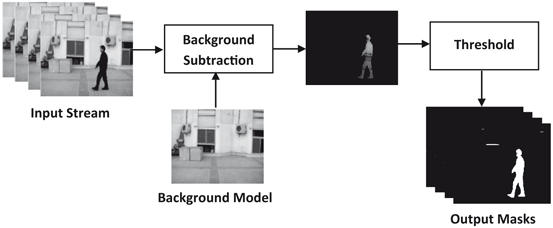

OpenCV has two implementations of a MOG background subtractor. Perhaps not
surprisingly, they are named `cv2.BackgroundSubtractorMOG`
and `cv2.BackgroundSubtractorMOG2`. The latter is a more recent and improved
implementation, which adds support for shadow detection, so we will use it.
As a starting point, let's take our basic background subtraction script from the [basic_motion_detection](https://github.com/ZahraEk/OpenCV-Course/blob/main/basic_motion_detection.ipynb). 

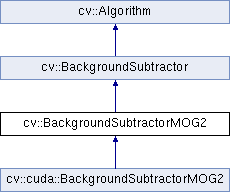

We will make the following modifications to it:
1. Replace our basic background subtraction model with a MOG background subtractor.

2. As input, use a video file instead of a camera.

3. Remove the use of Gaussian blur.

4. Adjust the parameters used in the thresholding, morphology, and contour analysis steps.

More details in :[📄OpenCV_Course.pdf](https://github.com/ZahraEk/OpenCV-Course/blob/main/OpenCV_Course.pdf) | pages 13-16

In [15]:
# Create a background subtractor using the MOG2 method with shadow detection enabled.
bg_subtractor = cv2.createBackgroundSubtractorMOG2(detectShadows=False)

# Define the kernel sizes for erosion and dilation
erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))

# Open the video file for reading
cap = cv2.VideoCapture("videos/videos_hallway.mpg")
      
# Capture a frame from the camera
success, frame = cap.read()
while success:
    
    # Apply background subtraction to get the foreground mask
    fg_mask = bg_subtractor.apply(frame)

    # Apply thresholding to create a binary image
    _, thresh = cv2.threshold(fg_mask, 244, 255, cv2.THRESH_BINARY)

    # Apply morphological erosion and dilation to smoothen the thresholded image
    cv2.erode(thresh, erode_kernel, thresh, iterations=2)
    cv2.dilate(thresh, dilate_kernel, thresh, iterations=2)

    # Find contours of objects in the thresholded image
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Loop through detected contours and draw bounding rectangles for large ones
    for c in contours:
        if cv2.contourArea(c) > 1000:
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
    
    cv2.imshow('MOG', fg_mask)
    cv2.imshow('Thresh', thresh)
    cv2.imshow('Detection', frame)

    k = cv2.waitKey(10)
    if k == 27:  # Escape
        break

    # Capture a frame from the camera
    success, frame = cap.read()

# Release the video capture object and close OpenCV windows
cap.release()
cv2.destroyAllWindows()

---

# KNN :

`cv2.createBackgroundSubtractorKNN` is a function in the OpenCV library that creates an instance of the K-Nearest Neighbors (KNN) background subtractor. The algorithm works by comparing each pixel in the current frame with its K nearest neighbours in the background model, which is updated dynamically. 

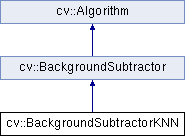

By modifying just five lines of code in our [MOG background subtraction](https://github.com/ZahraEk/OpenCV-Course/blob/main/mog.ipynb) script, we can use
a different background subtraction algorithm, different morphology parameters, and a
different video as input.
Just by replacing cv2.createBackgroundSubtractorMOG2 with
cv2.createBackgroundSubtractorKNN, we can we use a background subtractor based
on KNN clustering instead of MOG clustering:

`bg_subtractor = cv2.createBackgroundSubtractorKNN(detectShadows=True)`

Note that despite the change in algorithm, the detectShadows parameter is still
supported. Additionally, the apply method is still supported, so we do not need to change
anything related to the use of the background subtractor later in the script.

More details in :[OpenCV_Course.pdf](https://github.com/ZahraEk/OpenCV-Course/blob/main/OpenCV_Course.pdf) | pages 17-18

In [16]:
# Create a background subtractor using the KNN method with shadow detection enabled.
bg_subtractor = cv2.createBackgroundSubtractorKNN(detectShadows=True)

# Define the kernel sizes for erosion and dilation
erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 5))
dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17, 11))

# Open the video file for reading
cap = cv2.VideoCapture("videos/traffic.flv")
      
# Capture a frame from the camera
success, frame = cap.read()
while success:
    
    # Apply background subtraction to get the foreground mask
    fg_mask = bg_subtractor.apply(frame)

    # Apply thresholding to create a binary image
    _, thresh = cv2.threshold(fg_mask, 244, 255, cv2.THRESH_BINARY)

    # Apply morphological erosion and dilation to smoothen the thresholded image
    cv2.erode(thresh, erode_kernel, thresh, iterations=2)
    cv2.dilate(thresh, dilate_kernel, thresh, iterations=2)

    # Find contours of objects in the thresholded image
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Loop through detected contours and draw bounding rectangles for large ones
    for c in contours:
        if cv2.contourArea(c) > 1000:
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
    
    cv2.imshow('KNN', fg_mask)
    cv2.imshow('Thresh', thresh)
    cv2.imshow('Detection', frame)

    k = cv2.waitKey(10)
    if k == 27:  # Escape
        break

    # Capture a frame from the camera
    success, frame = cap.read()

# Release the video capture object and close OpenCV windows
cap.release()
cv2.destroyAllWindows()

---

# GMG :

`cv2.bgsegm.createBackgroundSubtractorGMG()` is a function in the OpenCV library that creates an instance of the Global Motion-based Background Subtraction-GMG background subtractor. This algorithm is based on the concept of global motion and is especially effective in situations where the camera is stationary or there is a certain global motion in the scene.

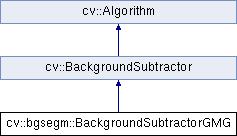

`bg_subtractor = cv2.bgsegm.createBackgroundSubtractorGMG(initializationFrames=120,decisionThreshold=0.7)`

This algorithm combines statistical background image estimation and per-pixel Bayesian segmentation.It uses first few (120 by default) frames for background modelling. It employs probabilistic foreground segmentation algorithm that identifies possible foreground objects using Bayesian inference. The estimates are adaptive; newer observations are more heavily weighted than old observations to accommodate variable illumination. Several morphological filtering operations like closing and opening are done to remove unwanted noise.

The GMG algorithm is especially suitable for situations where the background is fixed and the objects in the scene have a clear global movement pattern. Also, GMG does not support shadow detection.

More details in :[OpenCV_Course.pdf](https://github.com/ZahraEk/OpenCV-Course/blob/main/OpenCV_Course.pdf) | pages 19-20

In [17]:
# Create a background subtractor using the GMG method with shadow detection enabled.
bg_subtractor = cv2.bgsegm.createBackgroundSubtractorGMG()

# Define the  kernel sizes for erosion and dilation
erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 9))
dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17, 11))

# Open the video file for reading
cap = cv2.VideoCapture("videos/traffic.flv")
      
# Capture a frame from the camera
success, frame = cap.read()
while success:
    
    # Apply background subtraction to get the foreground mask
    fg_mask = bg_subtractor.apply(frame)

    # Apply thresholding to create a binary image
    _, thresh = cv2.threshold(fg_mask, 244, 255, cv2.THRESH_BINARY)

    # Apply morphological erosion and dilation to smoothen the thresholded image
    cv2.erode(thresh, erode_kernel, thresh, iterations=2)
    cv2.dilate(thresh, dilate_kernel, thresh, iterations=2)

    # Find contours of objects in the thresholded image
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Loop through detected contours and draw bounding rectangles for large ones
    for c in contours:
        if cv2.contourArea(c) > 1000:
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
    
    cv2.imshow('GMG', fg_mask)
    cv2.imshow('Thresh', thresh)
    cv2.imshow('Detection', frame)

    k = cv2.waitKey(10)
    if k == 27:  # Escape
        break

    # Capture a frame from the camera
    success, frame = cap.read()

# Release the video capture object and close OpenCV windows
cap.release()
cv2.destroyAllWindows()

---

**Comparison MOG2 vs KNN vs GMG :**


In [18]:
# Create a background subtractor 
bg_subtractor_MOG2 = cv2.createBackgroundSubtractorMOG2(detectShadows=True)
bg_subtractor_KNN = cv2.createBackgroundSubtractorKNN(detectShadows=True)
bg_subtractor_GMG = cv2.bgsegm.createBackgroundSubtractorGMG()

# Define the  kernel sizes for erosion and dilation
erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))

# Open the video file for reading
cap = cv2.VideoCapture("videos/videos_hallway.mpg")
      
# Capture a frame from the camera
success, frame = cap.read()
while success:
    
    fg_masks = []
    for bg_subtractor in (bg_subtractor_MOG2, bg_subtractor_KNN, bg_subtractor_GMG):
        fg_mask = bg_subtractor.apply(frame)
        fg_masks.append(fg_mask)

    for fg_mask, color in zip(fg_masks, [(0, 0, 255), (255, 0, 0), (0, 255, 0)]):
        # Apply thresholding to create a binary image
        _, thresh = cv2.threshold(fg_mask, 244, 255, cv2.THRESH_BINARY)

        # Apply morphological operations
        cv2.erode(thresh, erode_kernel, thresh, iterations=2)
        cv2.dilate(thresh, dilate_kernel, thresh, iterations=2)

        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Loop through detected contours and draw bounding rectangles for large ones
        for c in contours:
            if cv2.contourArea(c) > 1000:
                x, y, w, h = cv2.boundingRect(c)
                cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
                
            # Add text to the rectangles
            if color == (0, 0, 255):
                cv2.putText(frame, "MOG2", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
            elif color == (255, 0, 0):
                cv2.putText(frame, "KNN", (x, y+h+ 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
            elif color == (0, 255, 0):
                cv2.putText(frame, "GMG", (x+w+10, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    cv2.imshow('Detection', frame)

    k = cv2.waitKey(10)
    if k == 27:  # Escape
        break

    # Capture a frame from the camera
    success, frame = cap.read()

# Release the video capture object and close OpenCV windows
cap.release()
cv2.destroyAllWindows()